 # Prediction of users for scooter-rental using regression models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('scooter_rental_data.csv')

# Exploratory Data Analysis

In [4]:
df.head()

,date,hr,weather,temperature,feels-like-temperature,relative-humidity,windspeed,psi,guest-users,registered-users
0,2011-01-01,0,clear,66.7,95.0,81.0,0.0,3,21,164
1,2011-01-01,1,clear,65.0,93.2,80.0,0.0,35,54,417
2,2011-01-01,2,clear,65.0,93.2,80.0,0.0,38,35,356
3,2011-01-01,3,clear,66.7,95.0,75.0,0.0,35,19,129
4,2011-01-01,4,clear,66.7,95.0,75.0,0.0,11,-2,10


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17958 entries, 0 to 17957
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    17958 non-null  object 
 1   hr                      17958 non-null  int64  
 2   weather                 17958 non-null  object 
 3   temperature             17958 non-null  float64
 4   feels-like-temperature  17958 non-null  float64
 5   relative-humidity       17958 non-null  float64
 6   windspeed               17958 non-null  float64
 7   psi                     17958 non-null  int64  
 8   guest-users             17958 non-null  int64  
 9   registered-users        17958 non-null  int64  
dtypes: float64(4), int64(4), object(2)
memory usage: 1.4+ MB


In [6]:
# Changing date to datetime format
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')

# Creating additional time related features to make date useful in our analysis
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month_name()
df['dayofweek'] = df['date'].dt.day_name()

In [7]:
df.weather.value_counts()

weather
clear              11186
cloudy              4492
light snow/rain     1429
lear                 323
CLEAR                288
loudy                111
CLOUDY                95
LIGHT SNOW/RAIN       31
heavy snow/rain        3
Name: count, dtype: int64

In [8]:
# Rectify all the typing errors in weather column
df.weather = df.weather.str.lower()


def weather(x):
    if x == 'lear':
        return 'clear'
    elif x == 'loudy':
        return 'cloudy'
    elif x == 'heavy snow/rain':
        return 'light snow/rain'
    else: return x



In [9]:
df.weather = df.weather.apply(weather)
df.weather.value_counts()

weather
clear              11797
cloudy              4698
light snow/rain     1463
Name: count, dtype: int64

In [10]:
# Preparing our target column
df['total_users'] = df['guest-users'] + df['registered-users']
df['total_users']

0         185
1         471
2         391
3         148
4           8
         ... 
17953    2049
17954    3299
17955      10
17956     713
17957    4174
Name: total_users, Length: 17958, dtype: int64

In [11]:
# Deleting the columns after transformation

df = df.drop(columns=['date', 'guest-users', 'registered-users'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17958 entries, 0 to 17957
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   hr                      17958 non-null  int64  
 1   weather                 17958 non-null  object 
 2   temperature             17958 non-null  float64
 3   feels-like-temperature  17958 non-null  float64
 4   relative-humidity       17958 non-null  float64
 5   windspeed               17958 non-null  float64
 6   psi                     17958 non-null  int64  
 7   year                    17958 non-null  int32  
 8   month                   17958 non-null  object 
 9   dayofweek               17958 non-null  object 
 10  total_users             17958 non-null  int64  
dtypes: float64(4), int32(1), int64(3), object(3)
memory usage: 1.4+ MB


<Axes: xlabel='total_users', ylabel='Count'>

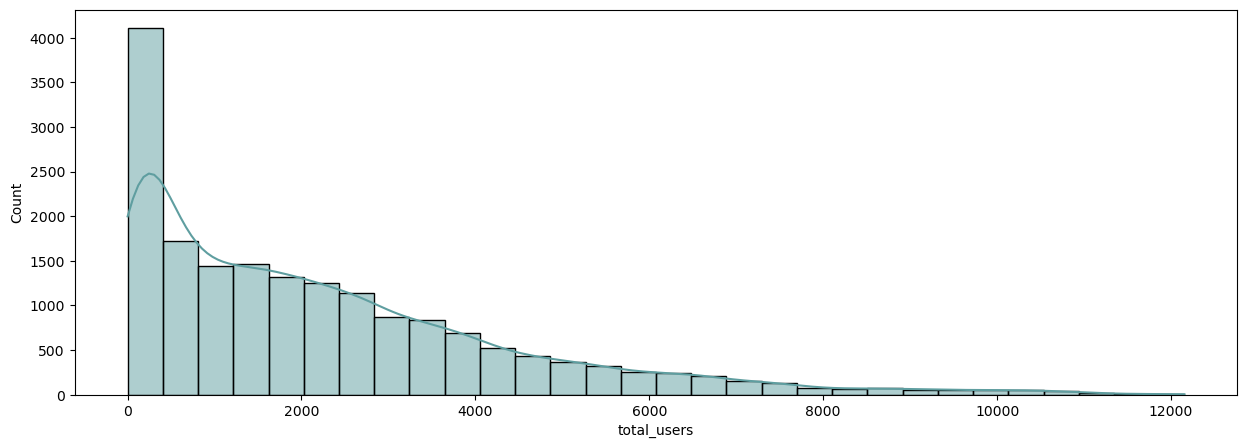

In [13]:
plt.figure(figsize=(15,5))
sns.histplot(df.total_users, bins=30, kde=True, color='cadetblue')

- We can see how positively skewed our target column is.  
- We will lose most of the data while triming outliers.
- We can take the log of total_users and see what happens.

In [14]:
df['log_total_users'] = np.log(df.total_users)

<Axes: xlabel='log_total_users', ylabel='Count'>

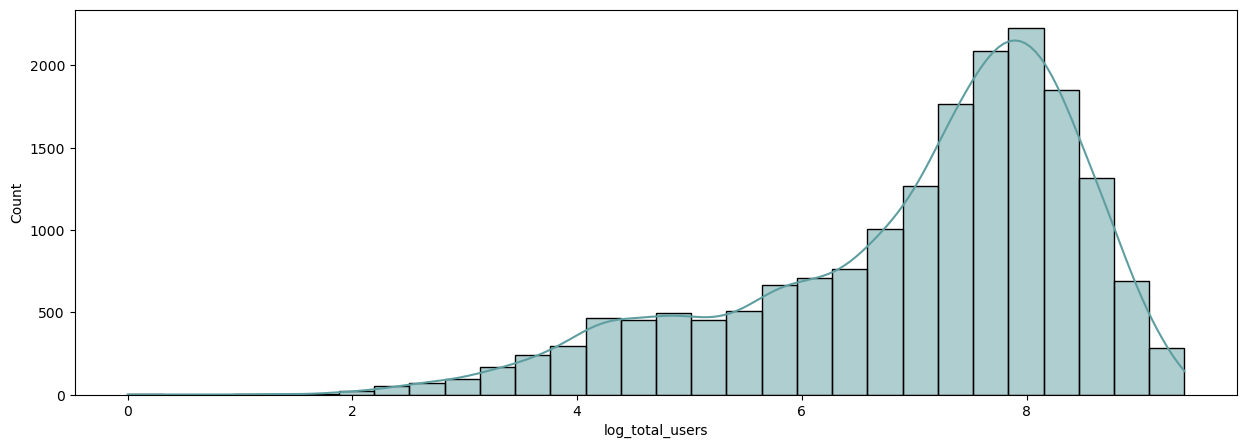

In [15]:
plt.figure(figsize=(15,5))
sns.histplot(df.log_total_users, bins=30, kde=True, color='cadetblue')

- After taking a logarithmic transformation, the distribution is still negatively skewed but looks much more normally distributed. We will be using the log-transformed variable as the new target as it has a more normal distribution which typically leads to a better model fit.  

In [16]:
df = df.drop('total_users', axis=1)

In [17]:
df.describe()

,hr,temperature,feels-like-temperature,relative-humidity,windspeed,psi,year,log_total_users
count,17958.000000,17958.000000,17958.000000,17958.000000,17958.000000,17958.000000,17958.000000,17958.000000
mean,11.533578,88.457512,117.332008,62.758993,12.733155,24.557300,2011.502450,7.014162
std,6.915319,16.285017,20.416251,19.266532,8.213750,14.451091,0.500008,1.483661
min,0.000000,48.100000,60.800000,0.000000,0.000000,0.000000,2011.000000,0.000000
25%,6.000000,75.200000,100.400000,48.000000,7.000000,12.000000,2011.000000,6.180017
50%,12.000000,88.700000,118.400000,63.000000,13.000000,24.000000,2012.000000,7.437795
75%,18.000000,102.200000,134.600000,78.000000,17.000000,37.000000,2012.000000,8.104326
max,23.000000,131.000000,179.600000,100.000000,57.000000,49.000000,2012.000000,9.405414


#### Comparing Total Users Across Different Years

<Figure size 1500x800 with 0 Axes>

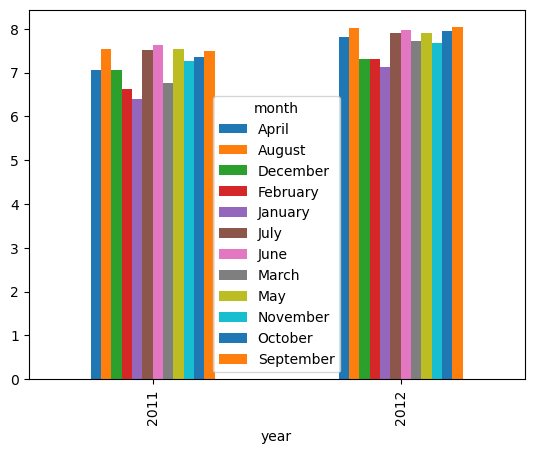

In [18]:
plt.figure(figsize=(15,8))
(df.pivot_table(index='year', columns='month', values='log_total_users', aggfunc='median')).plot(kind='bar')
plt.show()

- From the figure, we can see that the company has been successful in achieving growth in user acquisitions with the median and total number of users across all months have increased year on year.

<Axes: xlabel='month'>

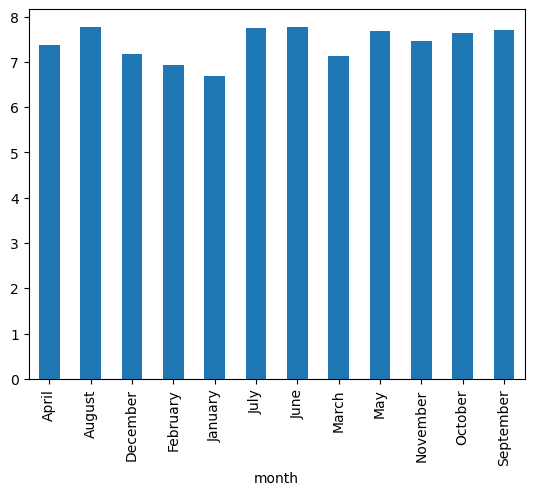

In [19]:
df.groupby('month')['log_total_users'].median().plot(kind='bar')

- As the months get hotter, the number of users increases.

<Axes: xlabel='dayofweek'>

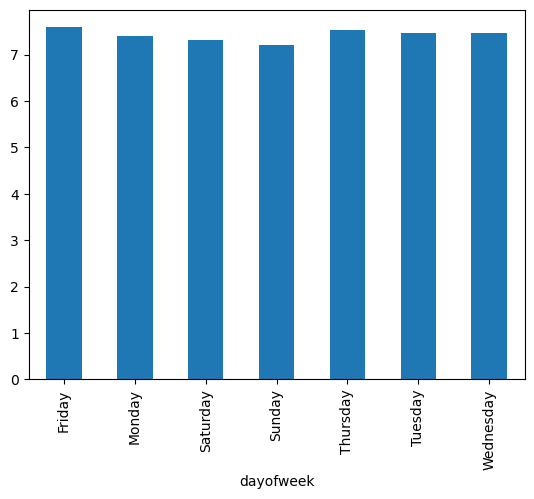

In [20]:
df.groupby('dayofweek')['log_total_users'].median().plot(kind='bar')

- Weekends have less number of users than the weekdays.
- Interesting to see that the number of users increase as days go from Monday to Friday.

<Axes: xlabel='weather'>

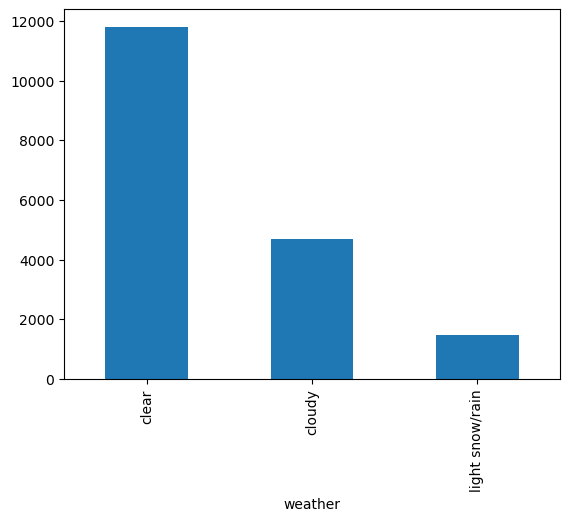

In [21]:
df.groupby('weather')['log_total_users'].count().plot(kind='bar')

- We can see there is a huge difference in total number of users when the weather gets better.

<Axes: xlabel='hr'>

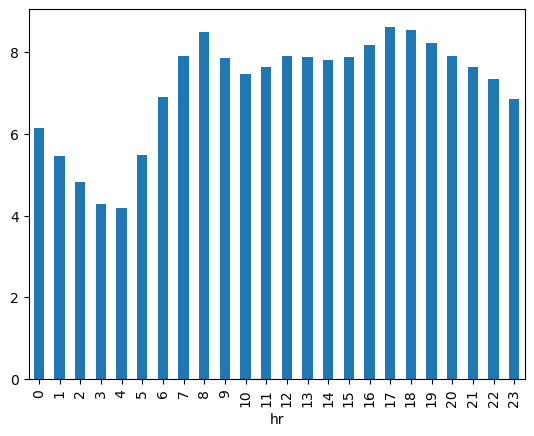

In [22]:
df.groupby('hr')['log_total_users'].median().plot(kind='bar')

- Only a few users rent scooters before 7. The peak hours start from 8 and again after 18 hr the number of users start declining.

<Axes: xlabel='temperature', ylabel='log_total_users'>

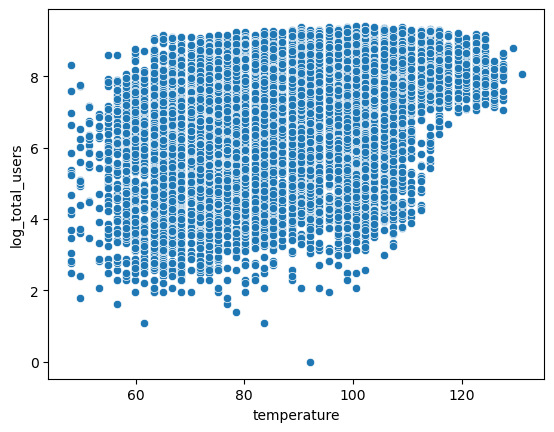

In [23]:
sns.scatterplot(x='temperature', y='log_total_users', data=df)

<Axes: xlabel='feels-like-temperature', ylabel='log_total_users'>

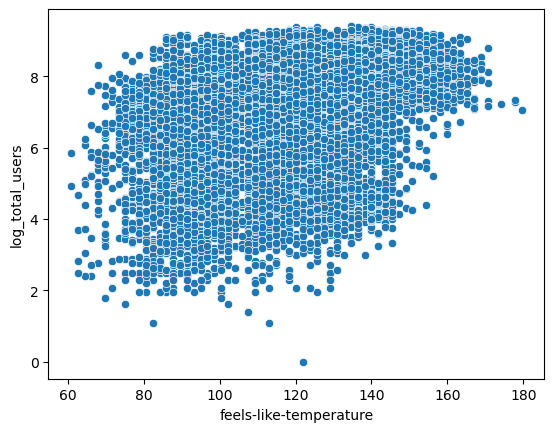

In [24]:
sns.scatterplot(x='feels-like-temperature', y='log_total_users', data=df)

- The results of temperature and feels-like-temperature are similiar, only feels-like-temperature has a larger scale.
- There are less number of very hot days but number of users in these days are always high.

<Axes: xlabel='relative-humidity', ylabel='log_total_users'>

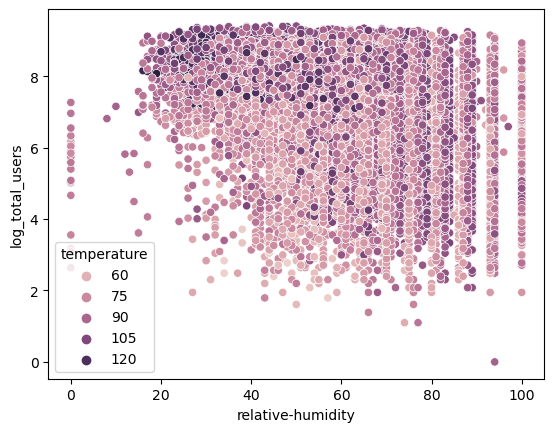

In [25]:
sns.scatterplot(x='relative-humidity', y='log_total_users', hue='temperature', data=df)

- Less number of days where relative humidity is less, but the number of users in these days are more.
- It has a negative correlation with total users.

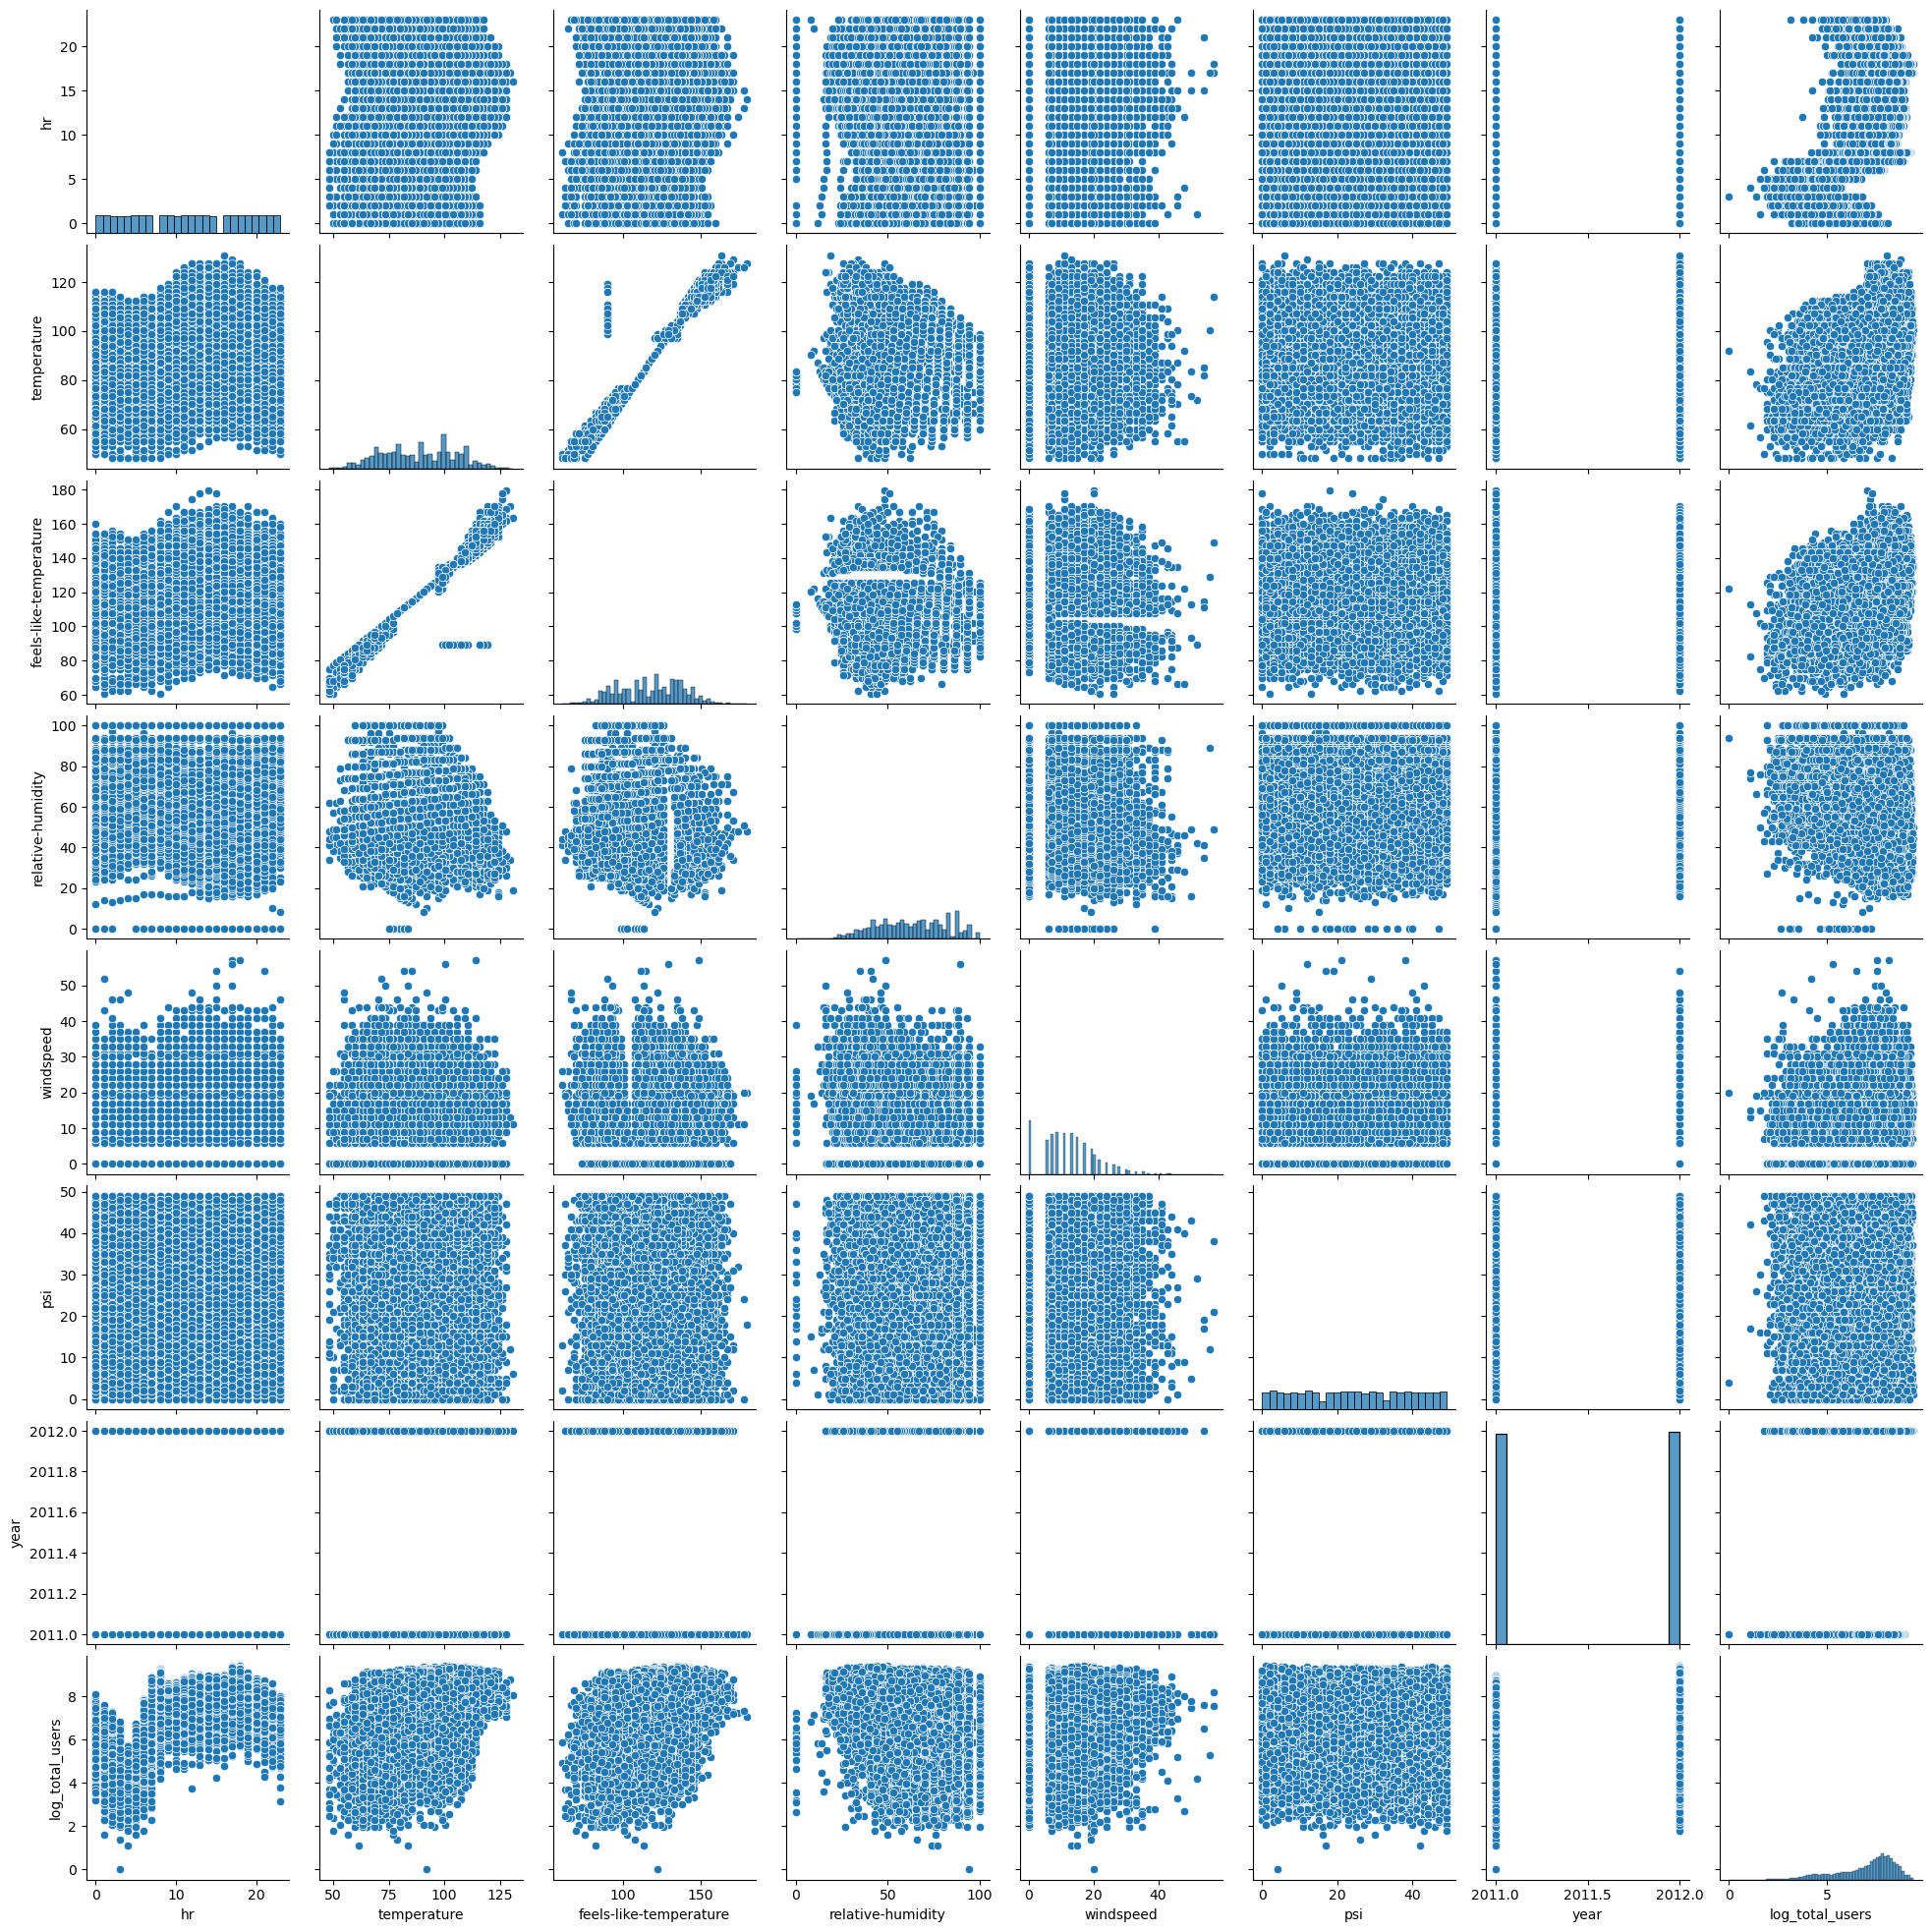

In [26]:
sns.pairplot(df)

- Psi seems to have no meaningful relationships.
- Windspeed seems to have a positive correlation with total users.

Lets check the correlation:

In [27]:
df_num = df.select_dtypes('number')

<Axes: >

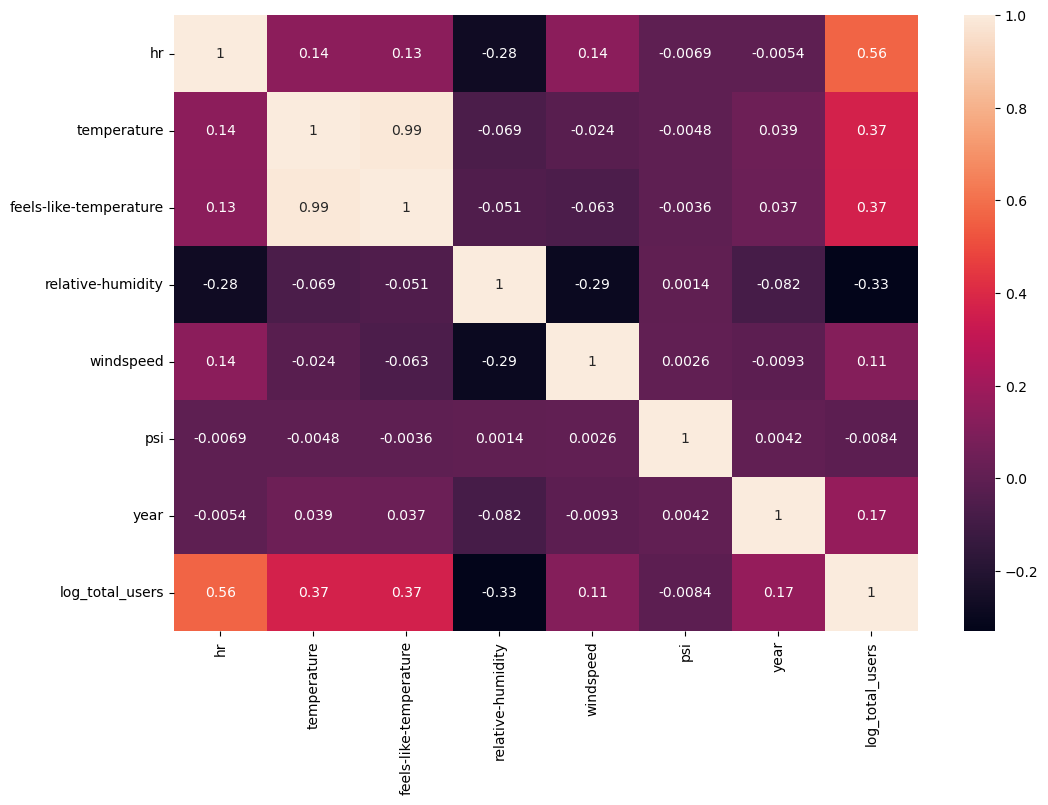

In [28]:
plt.figure(figsize=(12,8))
sns.heatmap(df_num.corr(), annot=True)

#### We will drop psi because of its low correlation with total users and feels-like-temperature as it is highly correlated with temperature.

In [29]:
df = df.drop(columns=['psi','feels-like-temperature'])

In [30]:
df.head()

,hr,weather,temperature,relative-humidity,windspeed,year,month,dayofweek,log_total_users
0,0,clear,66.7,81.0,0.0,2011,January,Saturday,5.220356
1,1,clear,65.0,80.0,0.0,2011,January,Saturday,6.154858
2,2,clear,65.0,80.0,0.0,2011,January,Saturday,5.968708
3,3,clear,66.7,75.0,0.0,2011,January,Saturday,4.997212
4,4,clear,66.7,75.0,0.0,2011,January,Saturday,2.079442


# Data Preprocessing

#### Checking for null values

In [31]:
df.isna().sum()

hr                   0
weather              0
temperature          0
relative-humidity    0
windspeed            0
year                 0
month                0
dayofweek            0
log_total_users      0
dtype: int64

In [32]:
df = df.replace(' ', np.nan)
df.isna().sum()

hr                   0
weather              0
temperature          0
relative-humidity    0
windspeed            0
year                 0
month                0
dayofweek            0
log_total_users      0
dtype: int64

In [33]:
df = df.replace('?', np.nan)
df.isna().sum()

hr                   0
weather              0
temperature          0
relative-humidity    0
windspeed            0
year                 0
month                0
dayofweek            0
log_total_users      0
dtype: int64

#### Checking outliers

<Axes: >

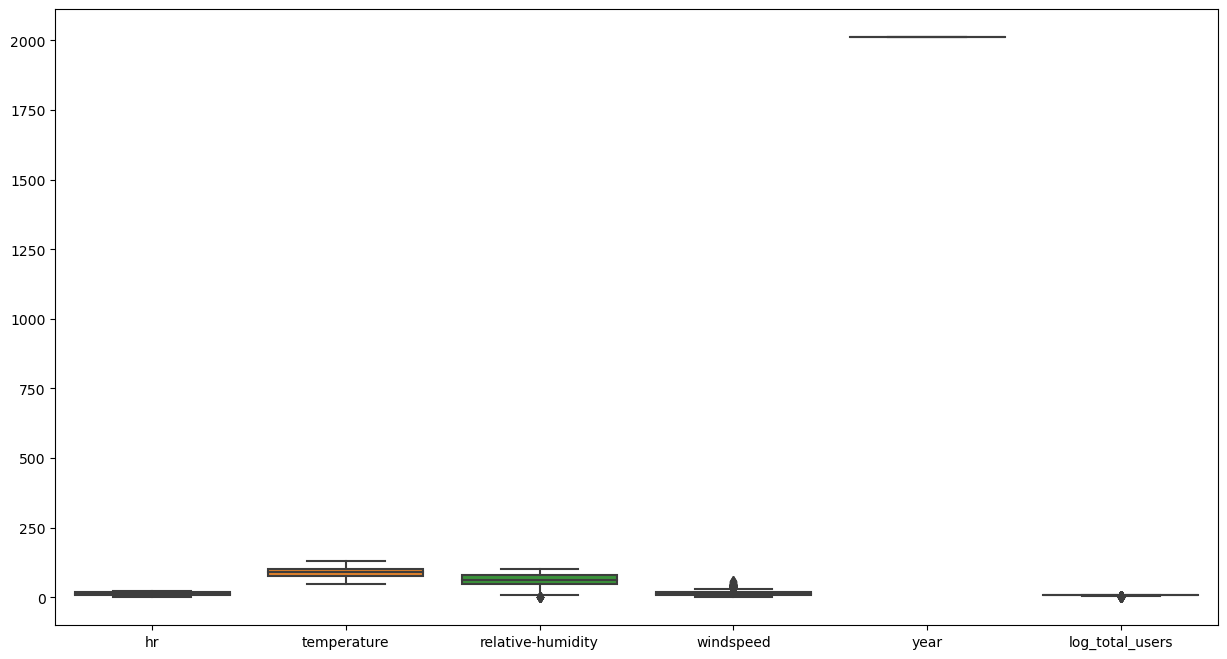

In [34]:
plt.figure(figsize=(15,8))
sns.boxplot(df)

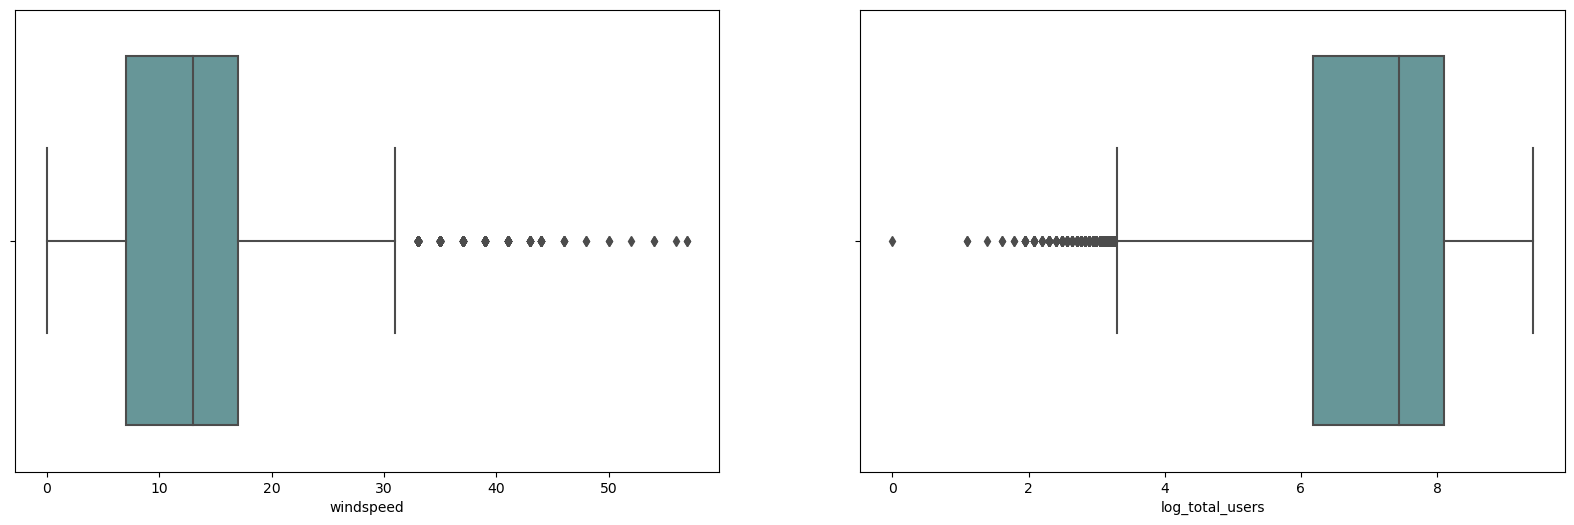

In [35]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
sns.boxplot(x=df['windspeed'], color='cadetblue')

plt.subplot(1,2,2)
sns.boxplot(x=df['log_total_users'], color='cadetblue')

plt.show()

In [36]:
df_num = df.select_dtypes('number')

In [37]:
Q1 = df_num.quantile(.25)
Q3 = df_num.quantile(.75)
IQR = Q3 - Q1
lower_b = Q1 - 1.5*IQR
upper_b = Q3 + 1.5*IQR

In [38]:
df = df[~((df_num < lower_b) | (df_num > upper_b)).any(axis=1)]

In [39]:
df.shape

(17274, 9)

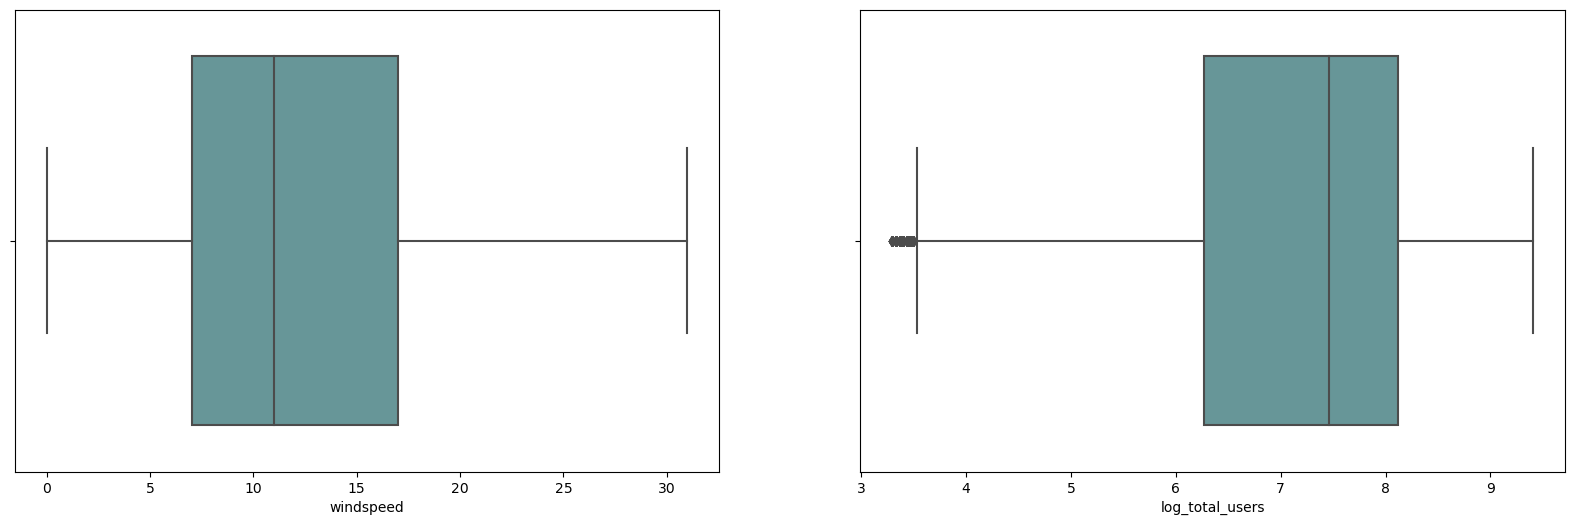

In [40]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
sns.boxplot(x=df['windspeed'], color='cadetblue')

plt.subplot(1,2,2)
sns.boxplot(x=df['log_total_users'], color='cadetblue')

plt.show()

No positive outliers remaining so we will now trim for lower bound only as to not trim relevant data.

In [41]:
df_num = df.select_dtypes('number')

In [42]:
Q1 = df_num.quantile(.25)
Q3 = df_num.quantile(.75)
IQR = Q3 - Q1
lower_b = Q1 - 1.5*IQR
upper_b = Q3 + 1.5*IQR

In [43]:
df = df[~(df_num < lower_b).any(axis=1)]

In [44]:
df.shape

(17145, 9)

<Axes: xlabel='log_total_users'>

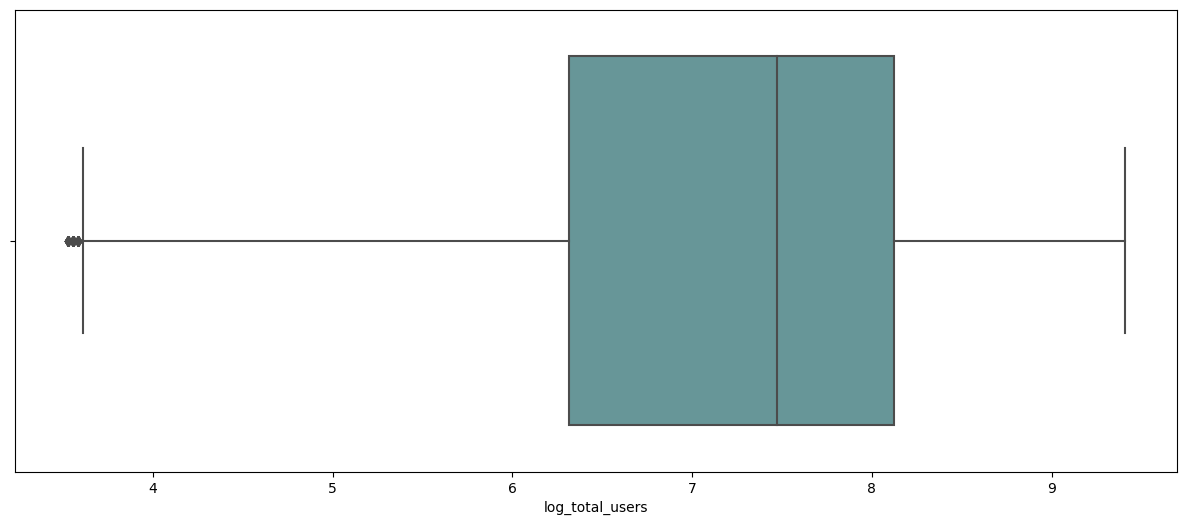

In [45]:
plt.figure(figsize=(15,6))
sns.boxplot(x=df['log_total_users'], color='cadetblue')

<Axes: >

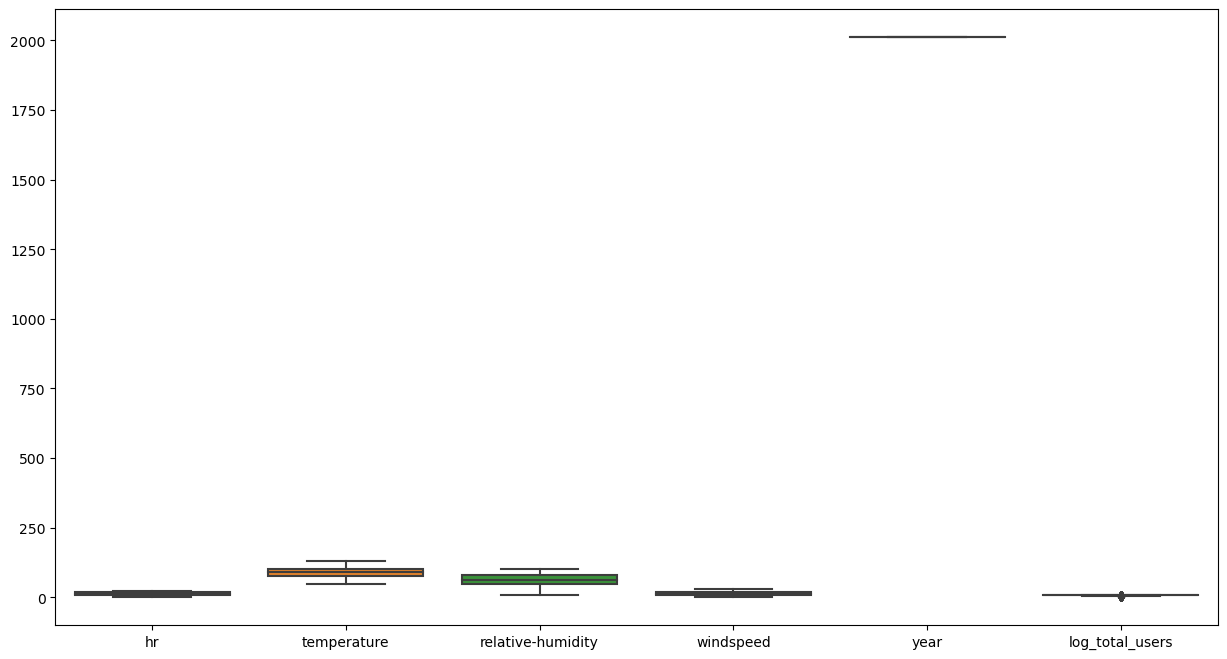

In [46]:
plt.figure(figsize=(15,8))
sns.boxplot(df)

Removed all outliers.

In [47]:
X = df.drop('log_total_users', axis=1)
y = df.log_total_users

In [48]:
X_num = X.select_dtypes('number')
X_cat = X.select_dtypes('object')

In [49]:
# Scaling the numeric features
from sklearn.preprocessing import MinMaxScaler

X_num_scaled = MinMaxScaler().fit_transform(X_num)

In [50]:
type(X_num_scaled)

numpy.ndarray

In [51]:
# Converting array to data frame

X_num_scaled = pd.DataFrame(X_num_scaled, columns=X_num.columns, index=X_num.index)
X_num_scaled.describe()

,hr,temperature,relative-humidity,windspeed,year
count,17145.000000,17145.000000,17145.000000,17145.000000,17145.000000
mean,0.508251,0.492995,0.597460,0.395057,0.506503
std,0.299981,0.195237,0.206995,0.242352,0.499972
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.260870,0.326900,0.434783,0.225806,0.000000
50%,0.521739,0.510253,0.597826,0.354839,1.000000
75%,0.782609,0.652593,0.760870,0.548387,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [52]:
# One Hot Encoding the categorical feature columns

X_cat_encoded = pd.get_dummies(X_cat, drop_first=False, dtype=int)

In [53]:
# Merging num and encoded into X

X = pd.concat([X_num_scaled, X_cat_encoded], axis=1)

In [54]:
 X.shape, X_num_scaled.shape, X_cat_encoded.shape

((17145, 27), (17145, 5), (17145, 22))

In [55]:
# Step 7: Check for NA in X and y; Check for shape compatibility
print("\nChecking for NAs and Shape Compatibility")
print(X.isnull().sum())
print(y.isnull().sum())
print(X.shape)
print(y.shape)


Checking for NAs and Shape Compatibility
hr                         0
temperature                0
relative-humidity          0
windspeed                  0
year                       0
weather_clear              0
weather_cloudy             0
weather_light snow/rain    0
month_April                0
month_August               0
month_December             0
month_February             0
month_January              0
month_July                 0
month_June                 0
month_March                0
month_May                  0
month_November             0
month_October              0
month_September            0
dayofweek_Friday           0
dayofweek_Monday           0
dayofweek_Saturday         0
dayofweek_Sunday           0
dayofweek_Thursday         0
dayofweek_Tuesday          0
dayofweek_Wednesday        0
dtype: int64
0
(17145, 27)
(17145,)


In [56]:
# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape) 
print(y_test.shape)

(13716, 27)
(3429, 27)
(13716,)
(3429,)


# MODEL FITTING

# 1. KNN Regressor:

In [58]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [59]:
#fitting the model

MSE_Train=[]
MSE_Test=[]
MAPE_Train=[]
MAPE_Test=[]
k=[]

for i in range(1,20):
    knn_reg = KNeighborsRegressor(n_neighbors=i)
    knn_reg.fit(X_train, y_train)
    
    #predicting the train data
    train_pred = knn_reg.predict(X_train)
    #calculating the train performance
    knn_mse_train = mean_squared_error(y_train, train_pred)
    knn_mape_train = mean_absolute_percentage_error(y_train, train_pred)
    
    #predicting the test data
    test_pred = knn_reg.predict(X_test)
    #calculating the test performance
    knn_mse_test = mean_squared_error(y_test, test_pred)
    knn_mape_test = mean_absolute_percentage_error(y_test, test_pred)
    
    MSE_Train.append(knn_mse_train)
    MSE_Test.append(knn_mse_test)
    MAPE_Train.append(knn_mape_train)
    MAPE_Test.append(knn_mape_test)
    k.append(i)

knn_res=pd.DataFrame({'k':k,'MSE Train':MSE_Train,'MSE Test':MSE_Test, 'MAPE Train':MAPE_Train,'MAPE Test':MAPE_Test})
knn_res

,k,MSE Train,MSE Test,MAPE Train,MAPE Test
0,1,0.000185,0.743593,0.000027,0.094127
1,2,0.181462,0.681928,0.046482,0.090897
2,3,0.291654,0.721911,0.059074,0.095848
3,4,0.374822,0.754962,0.069206,0.100183
4,5,0.444975,0.785355,0.076725,0.103661
5,6,0.511122,0.823670,0.083329,0.107419
6,7,0.568473,0.863810,0.088768,0.111084
7,8,0.615914,0.907443,0.093162,0.114637
8,9,0.662867,0.942678,0.097303,0.117341
9,10,0.704240,0.968260,0.100975,0.119352


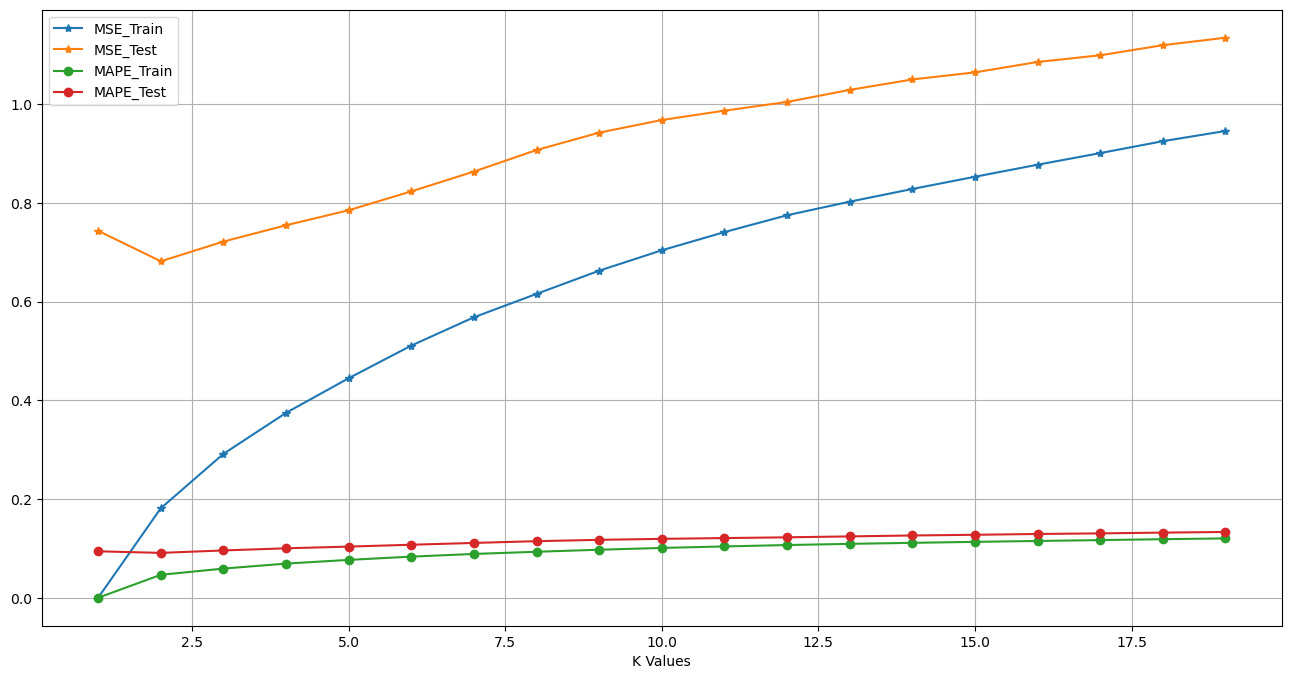

In [60]:
plt.figure(figsize=(16,8))
plt.plot(k, MSE_Train, marker='*', label='MSE_Train')
plt.plot(k, MSE_Test, marker='*', label='MSE_Test')
plt.plot(k, MAPE_Train, marker='o', label='MAPE_Train')
plt.plot(k, MAPE_Test, marker='o', label='MAPE_Test')

plt.xlabel('K Values')
plt.legend()
plt.grid(True)
plt.show()

#### K=5 seems to be the best fit for the model

In [61]:
knn = KNeighborsRegressor(n_neighbors=5)
model = knn.fit(X_train, y_train)

In [62]:
yhat_train_knn = model.predict(X_train)
yhat_test_knn = model.predict(X_test)

In [63]:
# At k=5:
knn_mse_train = 0.435317
knn_mse_test = 0.709069
knn_mape_train = 0.075748
knn_mape_test = 0.096647

# 2. Decision Tree Regressor:

In [64]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

In [65]:
parameters={"splitter":["best","random"],
            "max_depth" : [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "max_features":["auto","log2","sqrt",None]
           }

In [66]:
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeRegressor()

grid_search = GridSearchCV(dt, param_grid=parameters, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)


print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'max_depth': 16, 'max_features': None, 'min_samples_leaf': 9, 'splitter': 'random'}


In [67]:
dtr = DecisionTreeRegressor(max_depth=19, max_features='auto', min_samples_leaf=6, splitter='random', random_state=0)
model2 = dtr.fit(X_train, y_train)

In [68]:
# Feature importance
pd.DataFrame({'Features':model2.feature_names_in_, 'Importance':model2.feature_importances_})

,Features,Importance
0,hr,0.756791
1,temperature,0.061931
2,relative-humidity,0.003760
3,windspeed,0.002766
4,year,0.036615
5,weather_clear,0.002107
6,weather_cloudy,0.001462
7,weather_light snow/rain,0.015361
8,month_April,0.000961
9,month_August,0.000541


In [69]:
yhat_train_dt = model2.predict(X_train)
yhat_test_dt = model2.predict(X_test)

In [70]:
dt_mse_train = mean_squared_error(y_train, yhat_train_dt)
dt_mse_test = mean_squared_error(y_test, yhat_test_dt)
dt_mape_train = mean_absolute_percentage_error(y_train, yhat_train_dt)
dt_mape_test = mean_absolute_percentage_error(y_test, yhat_test_dt)

In [71]:
dt_mse_train, dt_mse_test

(0.11879893167985735, 0.1842896041256494)

In [72]:
dt_mape_train, dt_mape_test

(0.036167206681438975, 0.045685345894056095)

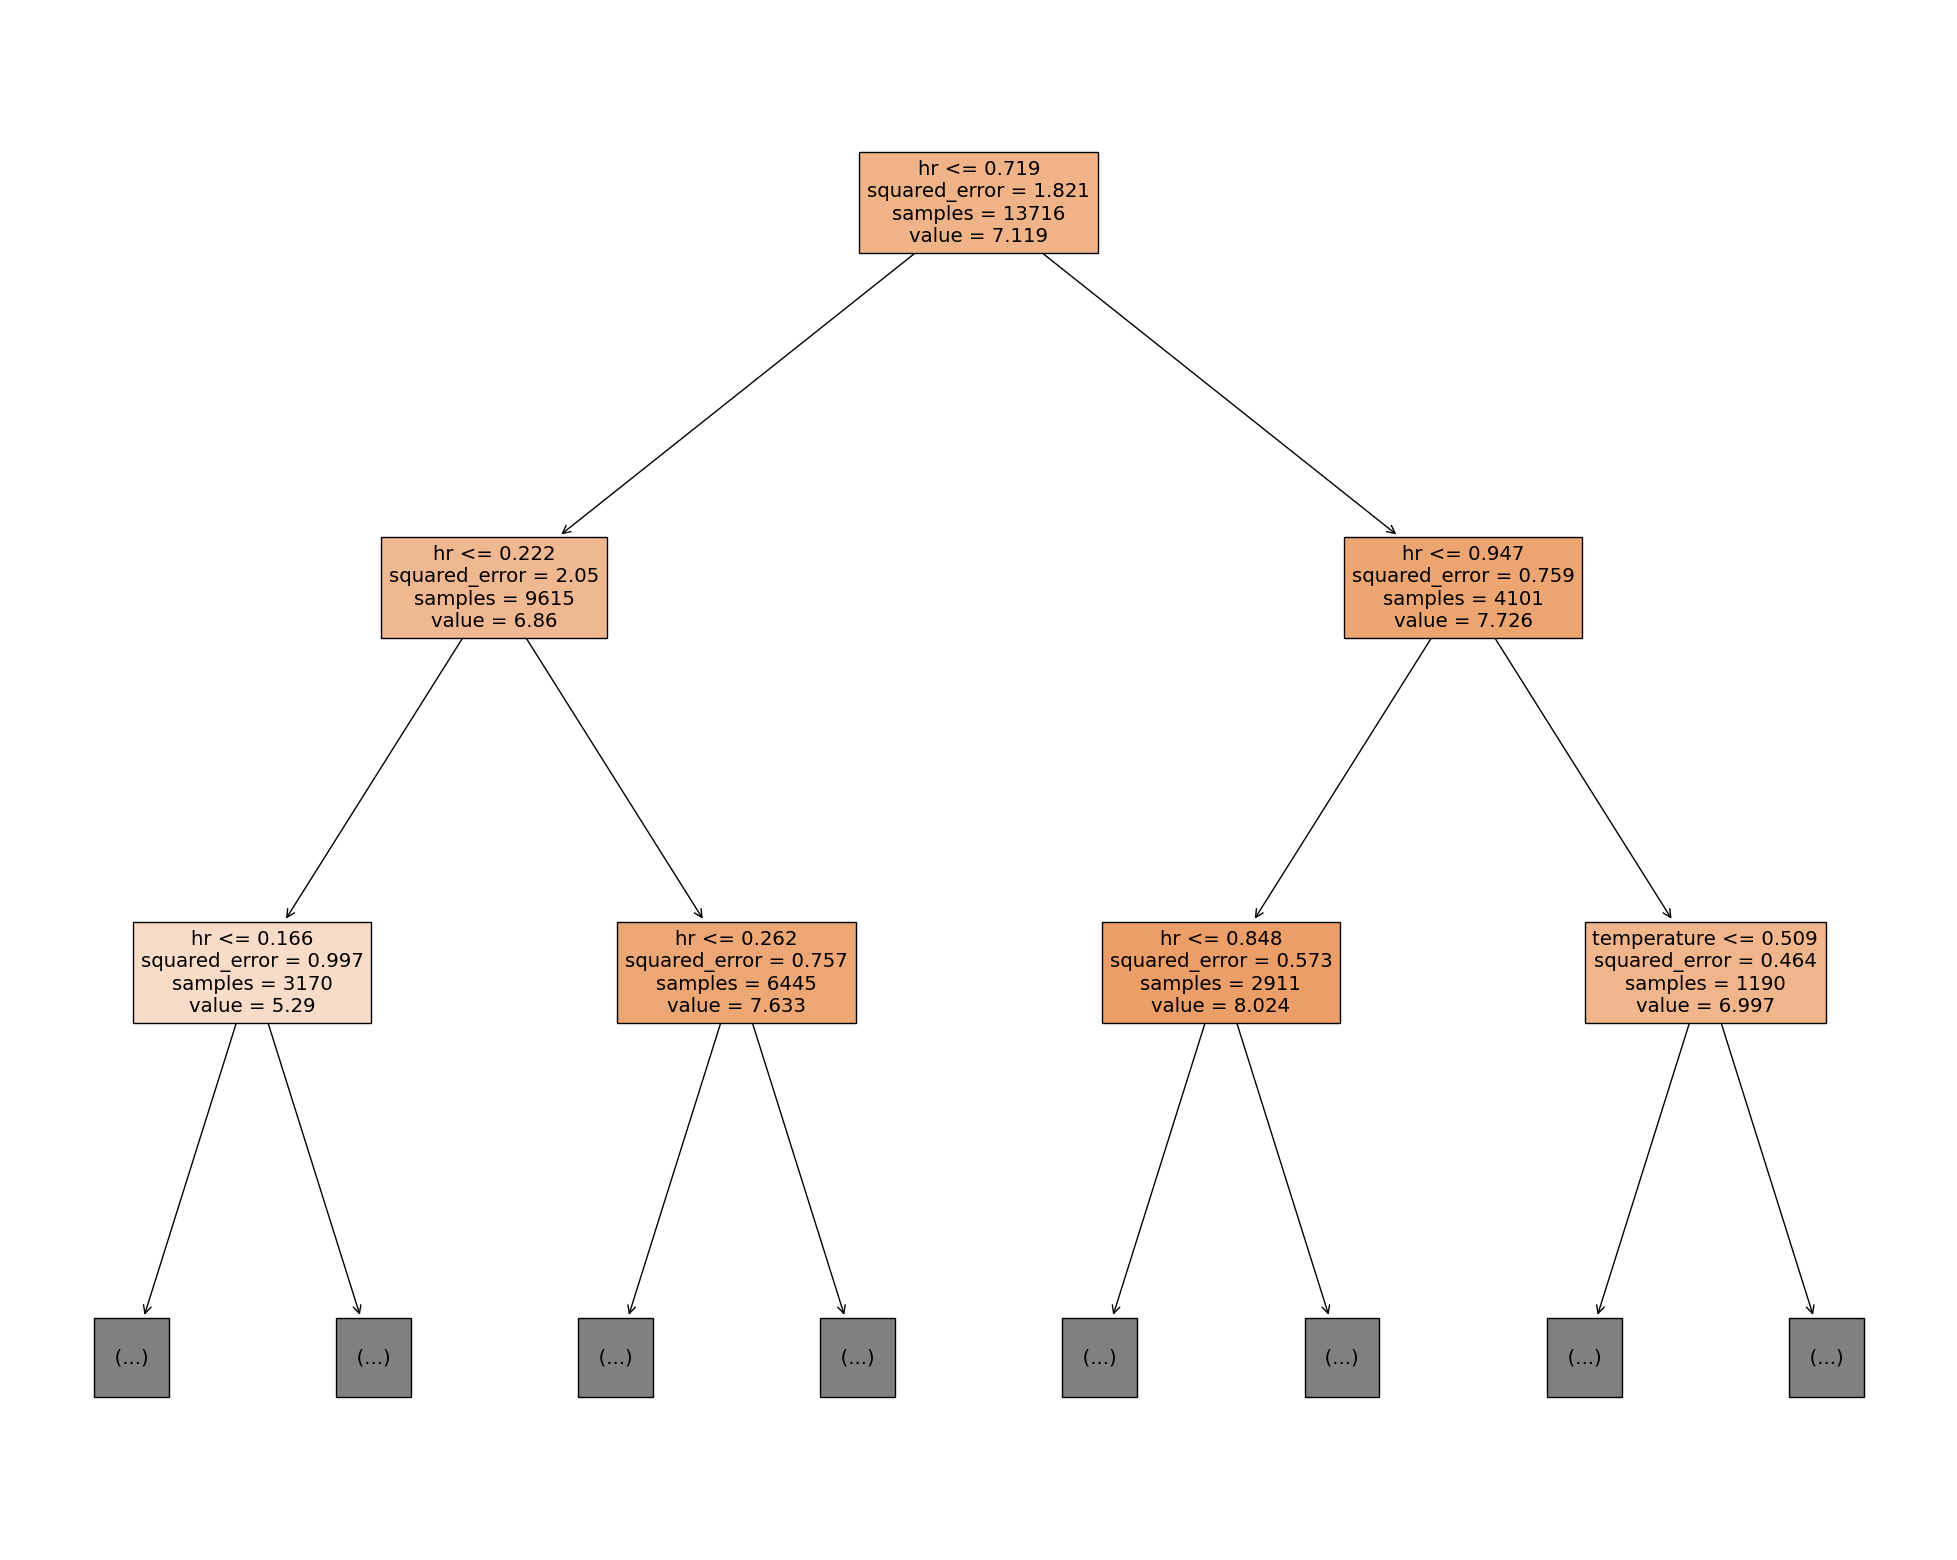

In [73]:
plt.figure(figsize=(25,20))
plot_tree(model2, max_depth=2, feature_names=X.columns, filled=True)
plt.show()

# 3. Linear Regression:

In [74]:
from sklearn.linear_model import LinearRegression

In [75]:
lr = LinearRegression()
model3 = lr.fit(X_train, y_train)

In [76]:
R_squared = model3.score(X_train, y_train)
R_squared

0.4663646890855462

In [77]:
model3.intercept_, model3.coef_

(3212836647404.8096,
 array([ 2.03251208e+00,  2.67077665e+00, -1.30817402e+00,  1.00023688e-01,
         3.69591114e-01, -4.41786421e+10, -4.41786421e+10, -4.41786421e+10,
         9.33626982e+11,  9.33626982e+11,  9.33626982e+11,  9.33626982e+11,
         9.33626982e+11,  9.33626982e+11,  9.33626982e+11,  9.33626982e+11,
         9.33626982e+11,  9.33626982e+11,  9.33626982e+11,  9.33626982e+11,
        -4.10228499e+12, -4.10228499e+12, -4.10228499e+12, -4.10228499e+12,
        -4.10228499e+12, -4.10228499e+12, -4.10228499e+12]))

In [78]:
yhat_train = model3.predict(X_train)
yhat_test = model3.predict(X_test)

In [79]:
# MSE of train and test

lr_MSE_train = mean_squared_error(y_train, yhat_train)
lr_MSE_test = mean_squared_error(y_test, yhat_test)
lr_MSE_train, lr_MSE_test

(0.9718055466808786, 1.018911740578725)

In [80]:
lr_MAPE_train = mean_absolute_percentage_error(y_train, yhat_train)
lr_MAPE_test = mean_absolute_percentage_error(y_test, yhat_test)
lr_MAPE_train,lr_MAPE_test

(0.12260542719080679, 0.1262436114207592)

In [81]:
summary = pd.DataFrame({'MODEL':['K-Nearest Neighbors','Decision Tree','Linear Regression'],
                       'Train_MSE':[knn_mse_train,dt_mse_train,lr_MSE_train],
                       'Test_MSE':[knn_mse_test,dt_mse_test,lr_MSE_test],
                        'Train_MAPE':[knn_mape_train,dt_mape_train,lr_MAPE_train],
                        'Test_MAPE':[knn_mape_test,dt_mape_test,lr_MAPE_test],
                        'R Sq':['NA','NA',R_squared]})

# Interpretation of the Results:

In [82]:
summary

,MODEL,Train_MSE,Test_MSE,Train_MAPE,Test_MAPE,R Sq
0,K-Nearest Neighbors,0.435317,0.709069,0.075748,0.096647,NA
1,Decision Tree,0.118799,0.184290,0.036167,0.045685,NA
2,Linear Regression,0.971806,1.018912,0.122605,0.126244,0.466365


1. KNN:
- The K-Nearest Neighbors model achieved relatively low MSE values for both the training and testing datasets, indicating good predictive performance. The MAPE values are also moderate, suggesting that the model's predictions are generally close to the actual values.

2. Decision Tress:
- The decision tree model here performed the best out of three. It produced three times lower MSE scores from KNN and reduced the MAPE to almost half, suggesting that this model's predictions are the most accurate of three.

3. Linear Regression:
- The Linear Regression model performed the worst out of three. Though it performed good but it has around 7 times the MSE of Decision Tree, R squared of the model is low as well meaning it does not adequately explain the variance in the label column.


In conclusion, among the evaluated models, the Decision Tree model appears to have the best performance based on the lower MSE and MAPE values. 